<a href="https://colab.research.google.com/github/mahapara2411/devopsgit/blob/main/Customer_Lifetime_Prediction_Using_Probabilistic_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Lifetimes==0.2.2.2

     |████████████████████████████████| 500 kB 5.2 MB/s 
  Created wheel for Lifetimes: filename=Lifetimes-0.2.2.2-py3-none-any.whl size=521869 sha256=41887742ce51fed53a3bec0e80998aefbfa452306afad564dfb78491ebcda0fb
  Stored in directory: /root/.cache/pip/wheels/ab/04/7d/368d8eab4dd36c80a3c533c3d6dcc78084c9831351938b0979
Successfully built Lifetimes


In [ ]:
#importing necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import xlrd
import pandas as pd
import datetime
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
import pickle
from lifetimes import ModifiedBetaGeoFitter
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving online_retail_II.xlsx to online_retail_II.xlsx


In [ ]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name = ["Year 2009-2010", "Year 2010-2011"]) #reading the excel file

In [ ]:
df1 = df["Year 2009-2010"]
df2 = df["Year 2010-2011"]

In [ ]:
df1.shape, df2.shape #checking for the shape of data

((525461, 8), (541910, 8))

In [ ]:
sum([df1.shape[0], df2.shape[0]])

1067371

In [ ]:
data = df1.append(df2) #combing the data

In [ ]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
data.shape

(1067371, 8)

In [ ]:
data.isnull().sum()/data.shape[0]*100 #checking for the null values

Invoice         0.000000
StockCode       0.000000
Description     0.410541
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.766873
Country         0.000000
dtype: float64

In [ ]:
# first drop the rows where the description is null
data.dropna(axis = 0, subset = ["Description"], inplace = True)

In [ ]:
data.isnull().sum() #Now let's check the data before droping these customer ID's

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
Customer ID    238625
Country             0
dtype: int64

In [ ]:
data[data["Customer ID"].isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [ ]:
data.iloc[575:, :]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
576,C489524,21258,VICTORIAN SEWING BOX LARGE,-1,2009-12-01 11:48:00,12.75,15614.0,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom
579,489526,85049E,SCANDINAVIAN REDS RIBBONS,12,2009-12-01 11:50:00,1.25,12533.0,Germany
580,489526,21976,PACK OF 60 MUSHROOM CAKE CASES,24,2009-12-01 11:50:00,0.55,12533.0,Germany
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
# We have to drop the rows where customer ID is null because it's a unique customer ID of each customer
# So it's better to drop rather than imputing it with some random value

data.dropna(axis = 0, subset = ["Customer ID"], inplace = True)

In [ ]:
data.isnull().sum() #Now's there is no null values available in our data

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [ ]:
data.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [ ]:
temp_df = pd.DataFrame(data["Country"].value_counts()) #creating the temporary data frame

In [ ]:
temp_df.head(10)

,Country
United Kingdom,741301
Germany,17624
EIRE,16195
France,14202
Netherlands,5140
Spain,3811
Belgium,3123
Switzerland,3064
Portugal,2504
Australia,1913


In [ ]:
names  = temp_df.index

In [ ]:
px.scatter(temp_df, y = "Country", color = names) #checking for the occurence of most countries in our data

As you can see the United Kingdom has the max transcations as compared to other countries. The one here to note is that the "United Kingdom" is the dominating class in this data which making our data looks kinda imbalanced between major class and the minority class.

You can cross check the same after de-selecting the United Kingdom from the above chart and see how your axis transforms.

In [ ]:
#Now let's check the total quantity and by country
data.groupby("Country").sum()["Quantity"].sort_values(ascending = False).head(10)
#data.groupby("Country").sum()["Quantity"].sort_values(ascending = False).tail(10)

Country
United Kingdom    8353502
Netherlands        381951
EIRE               313373
Denmark            235218
Germany            224581
France             183339
Australia          103706
Sweden              87737
Switzerland         51831
Spain               45156
Name: Quantity, dtype: int64

In [ ]:
#checking for the average price by country

px.scatter(data.iloc[:, [5, 7]].groupby(["Country"]).mean(), 
           y = "Price", size = "Price", title = "Average Price by Country", opacity = 0.48)


From the above dot plot we can conclude that the Singapore has the highest averge price followed by the Norway and Malta. Let's go deeper and see the distribution to better understand about our data.

In [ ]:
countries = data["Country"].unique() #extracting unique country names

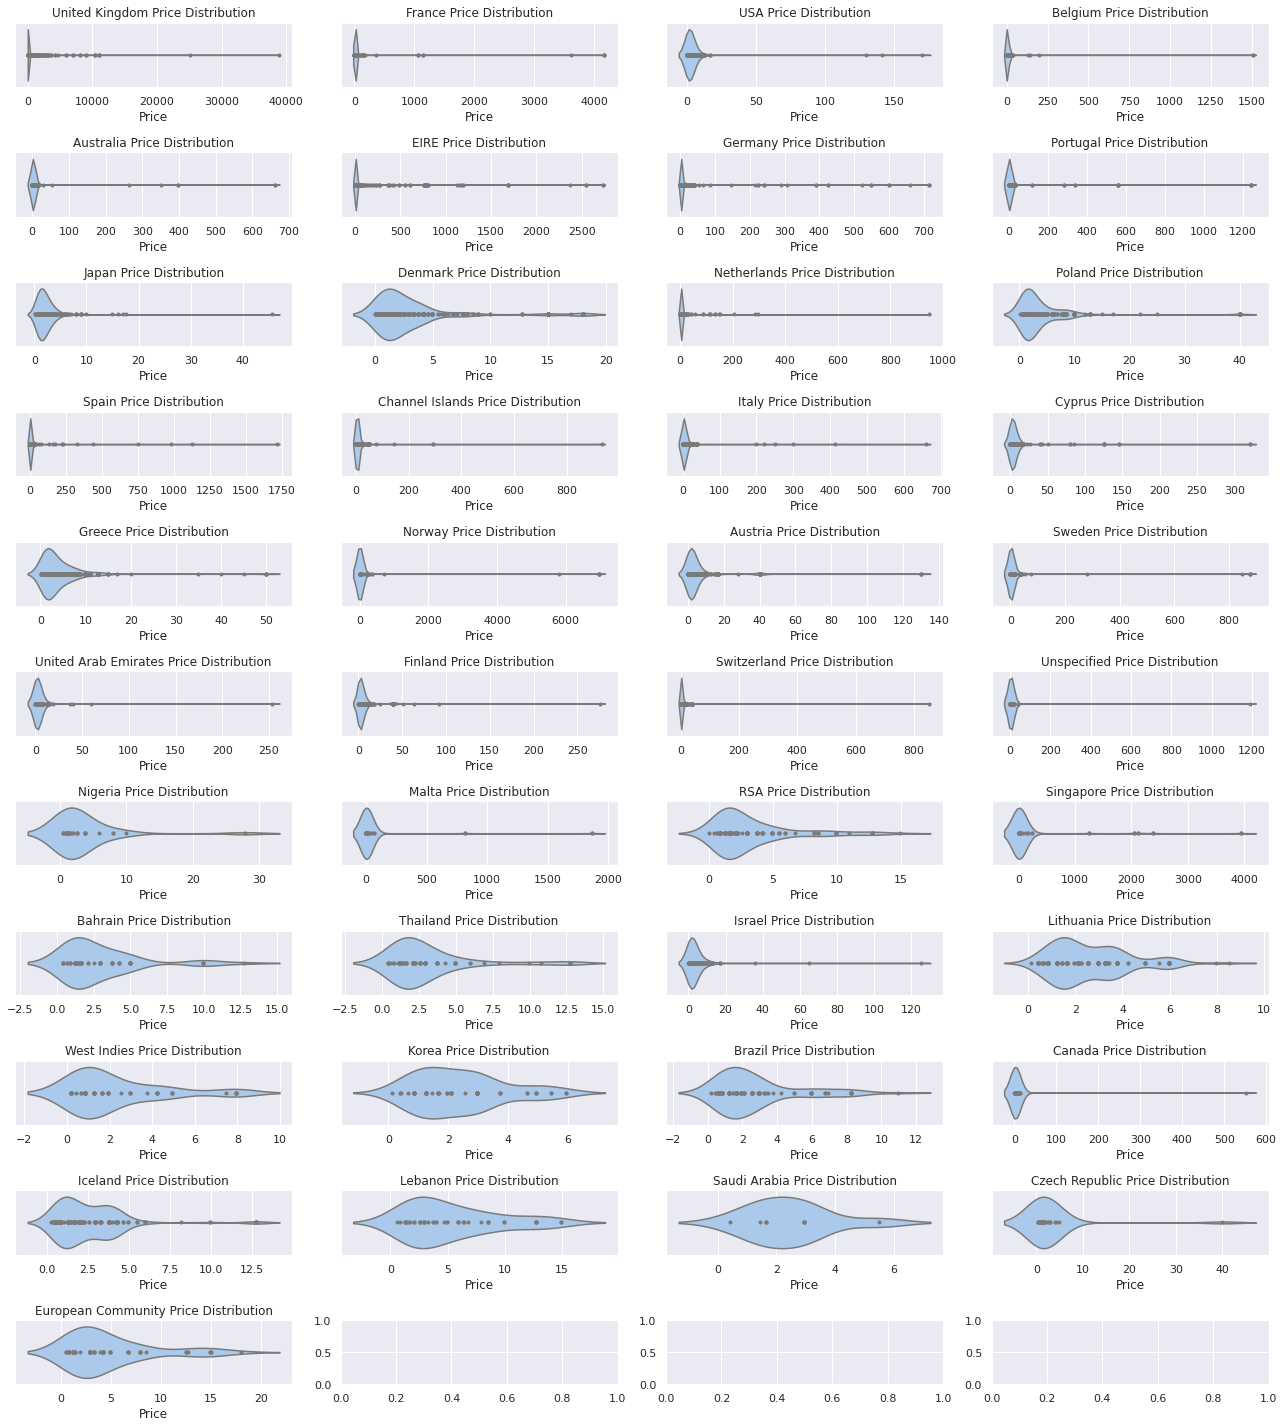

In [ ]:
#plotting the violin plot for the data
fig, ax = plt.subplots(11, 4, figsize=(18,20))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i, c in enumerate(countries):
    sns.violinplot(x = "Price", data = data[data["Country"] == c], ax = axes_[i], inner = "point", palette = "pastel")
    axes_[i].set_title(c + ' ' + "Price Distribution")
    plt.tight_layout()

From the above plot what I can interpret is that most of the data is pretty skewed and there is lot's of high extreme values that are present in the data.

In [ ]:
#Total Number of Unique Invoices 
len(data["Invoice"].unique())

44876

In [ ]:
temp_invoice_df = data.groupby("Invoice").sum()

In [ ]:
temp_invoice_df.reset_index(inplace = True)

In [ ]:
#Below are the top 30 invoices with total quantity purchased by them
temp_invoice_df.sort_values(by = "Quantity", ascending = False).head(30).iloc[:,:2].style.background_gradient(cmap = "Blues")

,Invoice,Quantity
11080,518505,87167
13425,524174,87167
3064,497946,83774
36942,581483,80995
20348,541431,74215
4379,501534,63974
2096,495194,63302
4693,502269,40000
1604,493819,25018
1047,491812,20524


In [ ]:
#Top 15 Invoices with average prices sorted from high to low
data.groupby(["Invoice"]).mean().head(15).iloc[:, [1]].sort_values("Price", ascending = False)

,Price
Invoice,
489444,141.000000
489447,130.000000
489434,4.081250
489436,3.730526
489437,3.628261
489439,3.560000
489440,3.150000
489446,3.118519
489441,3.042500


I have grouped the data by Invoice to see the average spend by Invoice Number. Here one thing interesting to see that the invoice with number 536374 & 536369 has outspent others. So to gain some better clarity, let's check these 2 invoices and get insights on how much quantity they have purchased so far.

In [ ]:
data[(data["Invoice"] == 489444) | (data["Invoice"] == 489447)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.0,12636.0,USA
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.0,12362.0,Belgium


As you can see above, These 2 invoices with invoice number 536374 and 536369 had only single transaction, that's why the average price was too high.

**INITIAL EDA INSIGHTS:**

1) Most of the customers are from the United Kingdom followed by the Germany, EIRE & France.

2) If we check the average price sale by countries, what we have observed is that Singapore has the highest averge price sale followed by the Norway and Malta.

3) Most of the countries data is skewed when it comes to the Price feature with lots of higher extreme values.

4) There are total 22190 uniques purchased happend so far.

5) We have also observed some of the Invoices who have purchased most of the quantities within 2 year of span.

6) When it comes to the average spend there are 2 invoices with number 536369 and 536374 having the highest average spent but upon inspection we also found the average product purchase was only 1 which is from USA followed by Belgium.

In [ ]:
#Let's look at the data once again & see what else insights we can get from the data itself
data.head(15)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


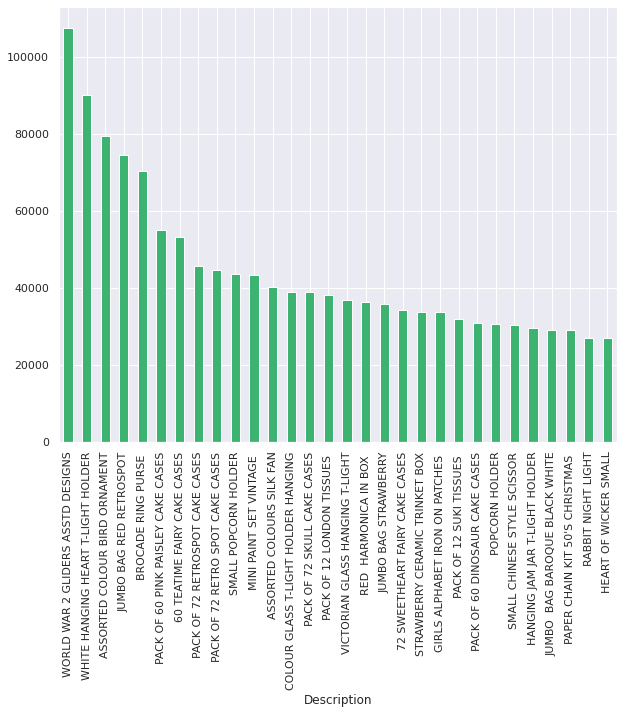

In [ ]:
#Let's check which product has been purchased more often so far
plt.figure(figsize=(10,8))
data.groupby("Description").sum().sort_values(by = "Quantity", ascending = False).head(30)["Quantity"].plot(kind = "bar", color = 'mediumseagreen')

In [ ]:
temp_data = data.copy() #creating a data copy point

In [ ]:
temp_data #use the temp data for adding some extra columns to the data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
#Date Time Analysis
temp_data.loc[:, "Month"] = data.InvoiceDate.dt.month
temp_data.loc[:, "Time"] = data.InvoiceDate.dt.time
temp_data.loc[:, "Year"] = data.InvoiceDate.dt.year
temp_data.loc[:, "Day"] = data.InvoiceDate.dt.day
temp_data.loc[:, "Quarter"] = data.InvoiceDate.dt.quarter
temp_data.loc[:, "Day of Week"] = data.InvoiceDate.dt.dayofweek

In [ ]:
#Mapping day of week
dayofweek_mapping = dict({0: "Monday", 
                         1: "Tuesday", 
                         2: "Wednesday" , 
                         3: "Thursday", 
                         4: "Friday", 
                         5: "Saturday", 
                         6: "Sunday"})

In [ ]:
#renaming the data values using map function
temp_data["Day of Week"] = temp_data["Day of Week"].map(dayofweek_mapping)

In [ ]:
temp_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Time,Year,Day,Quarter,Day of Week
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,07:45:00,2009,1,4,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12,12:50:00,2011,9,4,Friday
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,12,12:50:00,2011,9,4,Friday
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,12,12:50:00,2011,9,4,Friday
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,12,12:50:00,2011,9,4,Friday


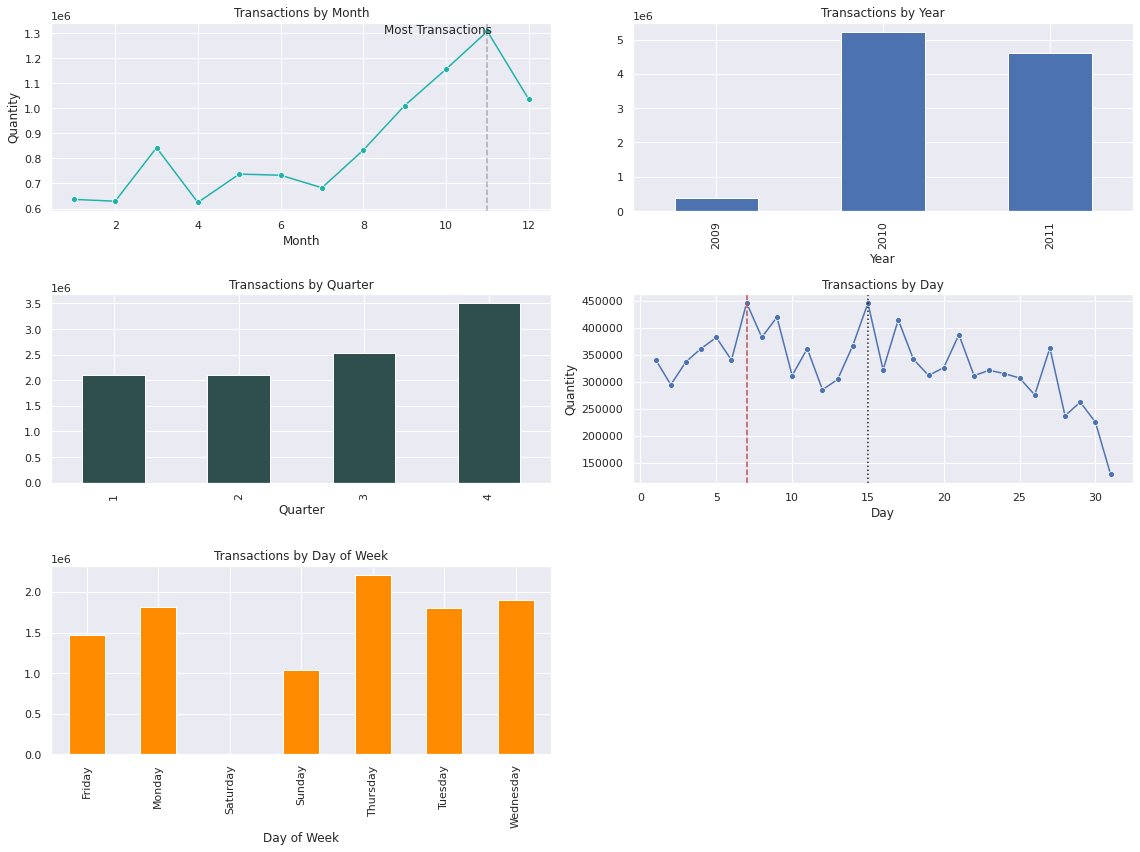

In [ ]:
#Plotting the above data
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
sns.lineplot(x = "Month", y = "Quantity", data = temp_data.groupby("Month").sum("Quantity"), marker = "o", color = "lightseagreen")
plt.axvline(11, color = "k", linestyle = '--', alpha = 0.3)
plt.text(8.50, 1.3e6, "Most Transactions")
plt.title("Transactions by Month")
plt.subplot(3,2,2)
temp_data.groupby("Year").sum()["Quantity"].plot(kind = "bar")
plt.title("Transactions by Year")
plt.subplot(3,2,3)
temp_data.groupby("Quarter").sum()["Quantity"].plot(kind = "bar", color = "darkslategrey")
plt.title("Transactions by Quarter")
plt.subplot(3,2,4)
sns.lineplot(x = "Day", y = "Quantity", data = temp_data.groupby("Day").sum("Quantity"), marker = "o", )
plt.axvline(7, color = 'r', linestyle = '--')
plt.axvline(15, color = 'k', linestyle = "dotted")
plt.title("Transactions by Day")
plt.subplot(3,2,5)
temp_data.groupby("Day of Week").sum()["Quantity"].plot(kind = "bar", color = "darkorange")
plt.title("Transactions by Day of Week")
plt.tight_layout()
plt.show()

As we can see, in 2009 the transactions is quite low as compared to 2010 and 2011. But as if now, we don't know the reason behind this so let's investigate why 2009 is low as compared to other 2 years.

In [ ]:
print("Total Number of Countries in 2009: {}".format(len(temp_data[temp_data["Year"] == 2009]["Country"].unique())))
print("Total Number of Transactions in 2009: {}".format(temp_data[temp_data["Year"] == 2009]["Quantity"].sum()))
print("--------------------------------------------")
print("Total Number of Countries in 2009: {}".format(len(temp_data[temp_data["Year"] == 2010]["Country"].unique())))
print("Total Number of Transactions in 2009: {}".format(temp_data[temp_data["Year"] == 2010]["Quantity"].sum()))
print("--------------------------------------------")
print("Total Number of Countries in 2009: {}".format(len(temp_data[temp_data["Year"] == 2011]["Country"].unique())))
print("Total Number of Transactions in 2009: {}".format(temp_data[temp_data["Year"] == 2011]["Quantity"].sum()))

Total Number of Countries in 2009: 23
Total Number of Transactions in 2009: 390286
--------------------------------------------
Total Number of Countries in 2009: 37
Total Number of Transactions in 2009: 5233315
--------------------------------------------
Total Number of Countries in 2009: 36
Total Number of Transactions in 2009: 4610527


Through this analysis what conclusion we can make is that may be the company has started their operations in other countries and started to expand their business further.

In [ ]:
_2009 = temp_data[temp_data["Year"] == 2009]["Country"].unique()
_2010 = temp_data[temp_data["Year"] == 2010]["Country"].unique()
_2011 = temp_data[temp_data["Year"] == 2011]["Country"].unique()

In [ ]:
#checking for the countries which are available in  2010 and 2011 but not in 2009.

no_cols = []

for i in (_2010):
    if i not in _2009:
        no_cols.append(i)
print("These are the values which are not present in 2009: {}".format(no_cols))

These are the values which are not present in 2009: ['Unspecified', 'Nigeria', 'Malta', 'RSA', 'Singapore', 'Bahrain', 'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Korea', 'Brazil', 'Canada', 'Iceland']


In [ ]:
temp = data.groupby(["Country", "Description"]).sum()["Quantity"]

In [ ]:
temp = pd.DataFrame(temp)

In [ ]:
top_8_countries = ["United Kingdom", "Netherlands", "EIRE", "Denmark", "Germany", "France", "Australia", "Sweden"]

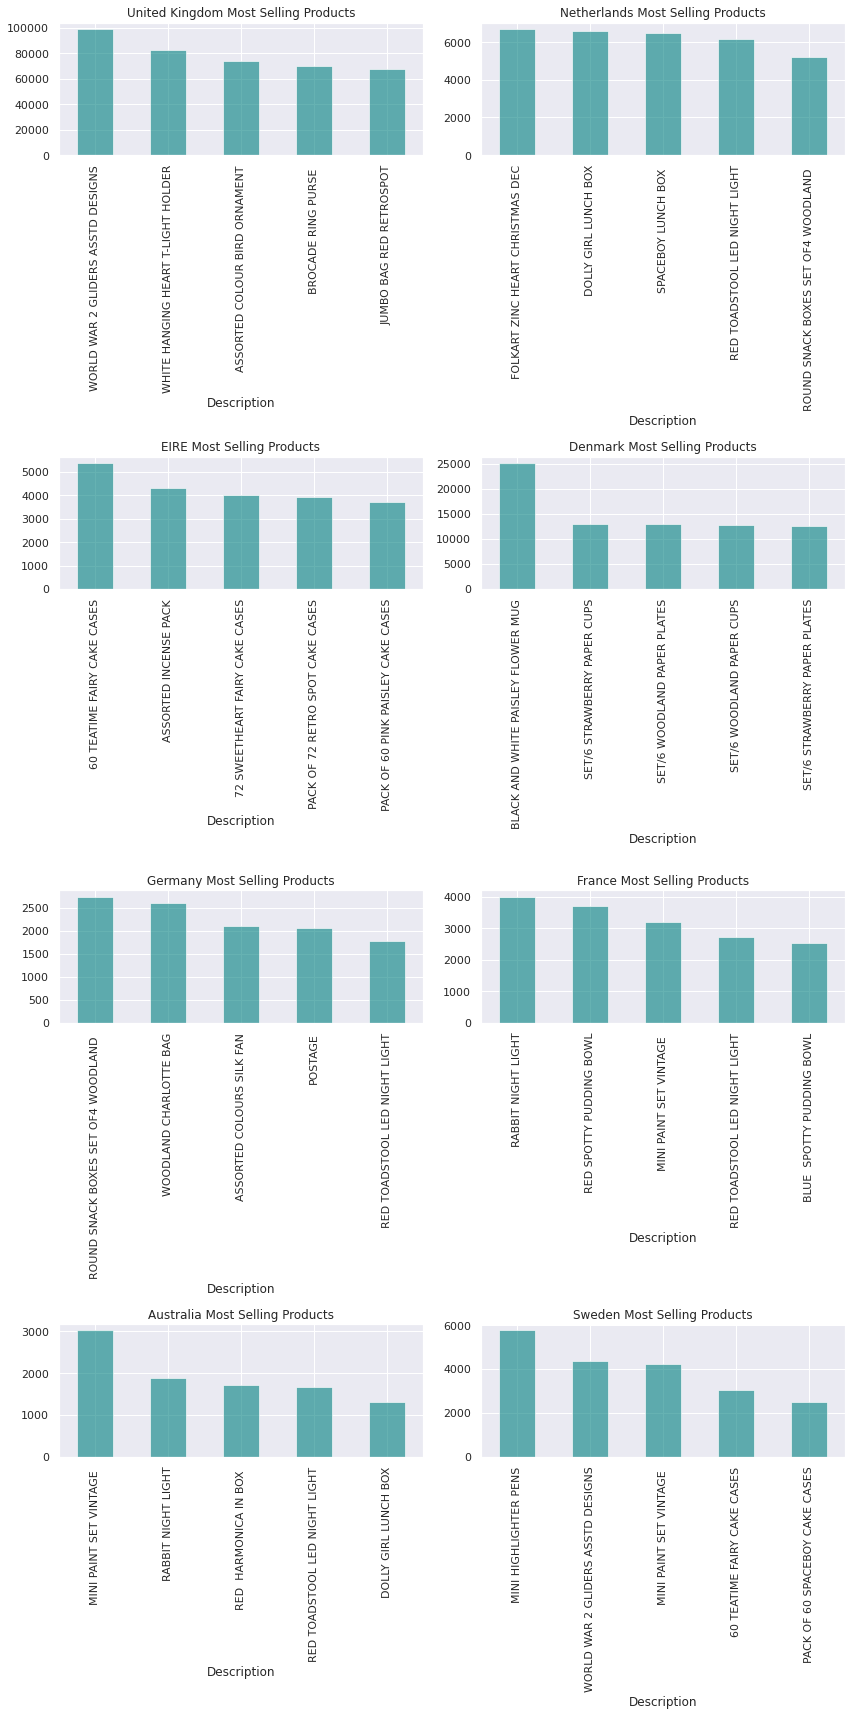

In [ ]:
x = 1
plt.figure(figsize=(12,24))
for x, c in enumerate(top_8_countries):
    ax = plt.subplot(4,2, x+1)
    plt.title(c + ' '+ "Most Selling Products")
    temp.loc[c].sort_values(by = "Quantity", ascending = False)["Quantity"].head(5).plot(kind = "bar", ax = ax, color = "teal", alpha = 0.6)
    plt.tight_layout()

**Bottom 8 Countries with Mostly Purchased Products**

In [ ]:
least_8_country = ["Saudi Arabia", "Nigeria", "Lebanon", "West Indies", "European Community", "Brazil", "Czech Republic", "Korea"]

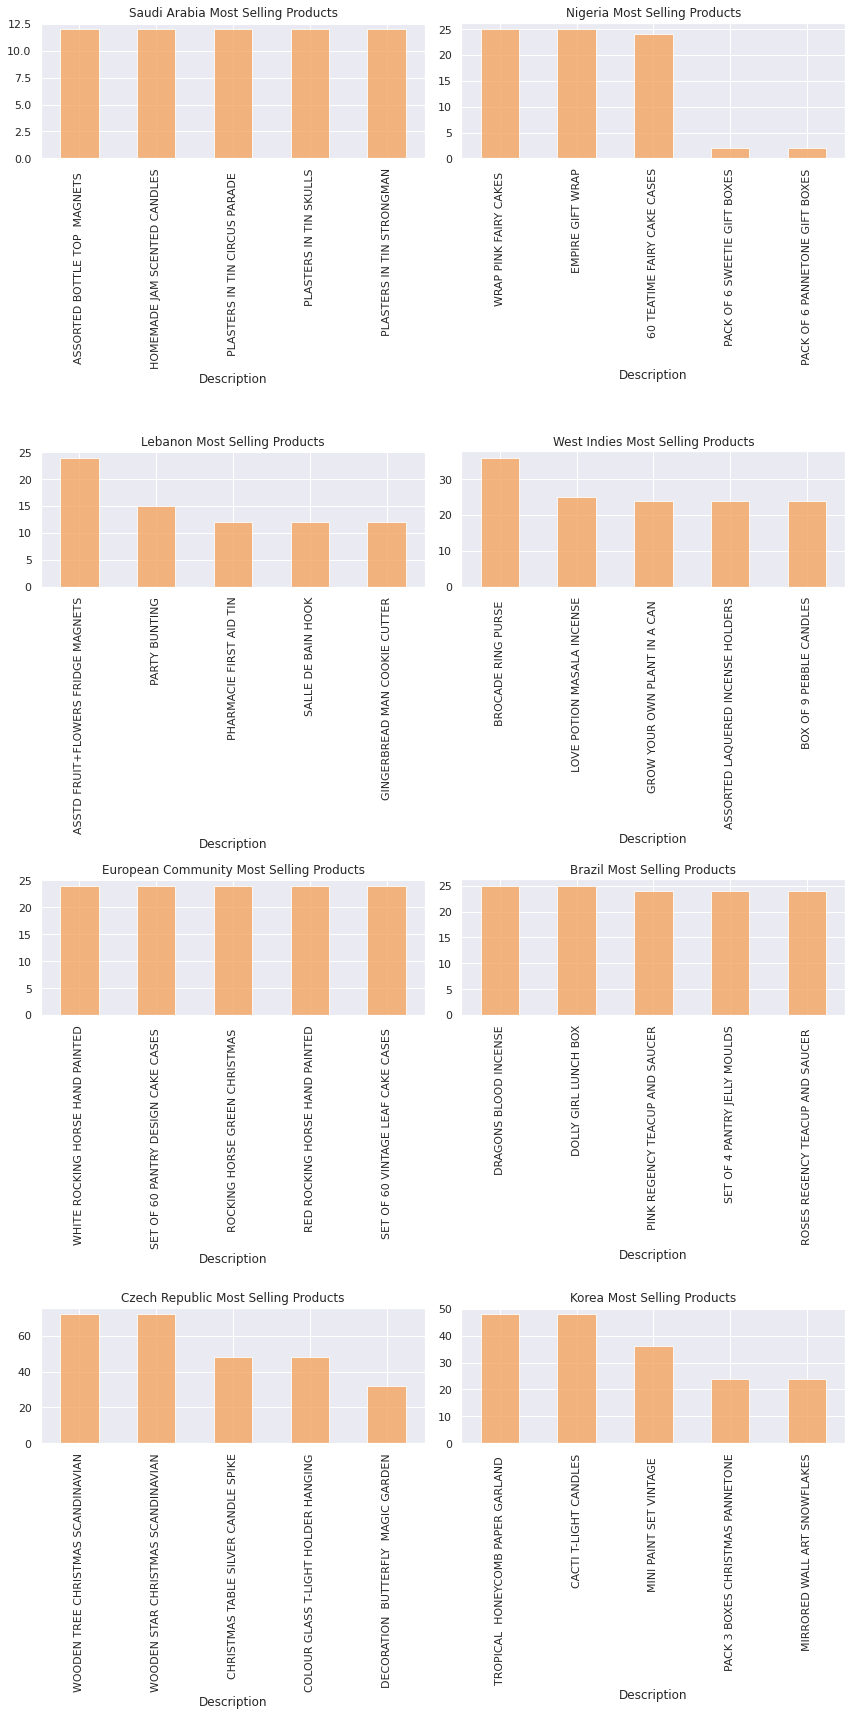

In [ ]:
x = 1
plt.figure(figsize=(12,24))
for x, c in enumerate(least_8_country):
    ax = plt.subplot(4,2, x+1)
    plt.title(c + ' '+ "Most Selling Products")
    temp.loc[c].sort_values(by = "Quantity", ascending = False)["Quantity"].head(5).plot(kind = "bar", ax = ax, color = "sandybrown", alpha = 0.8)
    
    plt.tight_layout()


EDA INSIGHTS:
1) Our Top 5 Best Selling Products are World War 2 Gliders, White Hanging Heart, Assorted Colour Bird, Jumbo Bag Red, Brocade Ring.

2) Most Transactions happened in the month of Novemeber which is evident due to festive seasons.

3) 2010 is the year in which we have the most transactions followed by the 2011

4) Q4 being the highest when it comes transactions.

5) It also observed that in the end of the 1st week and starting of the 3rd week, people tends to buy more.

6) People loves to shop on Thursday followed by Tuesday and Wednesday.



RFM Estimation - (Recency, Frequency, Monetary)¶
RFM stands for frequency, recency & monetary is a marketing technique which is used to find the best customers by analyzing their past purchasing behavior. It includes how frequently they have purchased, what is the total amount that they have spend so far, what was the last time they have purchased from our online store so on & so forth.....

In [ ]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
data["TotalPrice"] = data["Quantity"]*data["Price"]

In [ ]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [ ]:
import lifetimes

In [ ]:
import datetime as dt

In [ ]:
# Determining the analysis date for the recency
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)

In [ ]:
#calculating the recency, frequency, T, monetary_value
cltv_df = data.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                         lambda date: (today_date - date.min()).days],
                                         'Invoice': lambda num: num.nunique(),
                                         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})


cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0,400,726,17,-64.68
12347.0,402,405,8,5633.32
12348.0,362,439,5,2019.40
12349.0,716,736,5,4404.54
12350.0,0,311,1,334.40


In [ ]:
cltv_df = cltv_df.reset_index() #resetting the index

In [ ]:
cltv_df.shape

(5942, 5)

A) T - T is the length of the period of observation for the customer based on the value used for freq (the default is frequency is day). This can also be thought of the length of time between a customer’s first purchase and the end of the period, measured in increments defined by freq.

B) Recency - Recency is the point (relative to their own period of observation) at which the customer made their most recent repeat purchase. This can also be thought of the length of time between a customer’s first and last purchase for the period, measured in increments defined by freq.

C) Frequency - Frequency is the number of repeat purchases the customer made during the observation period.

D) Monetary - monetary_value is the average monetary amount of each repeat purchase made by a customer.

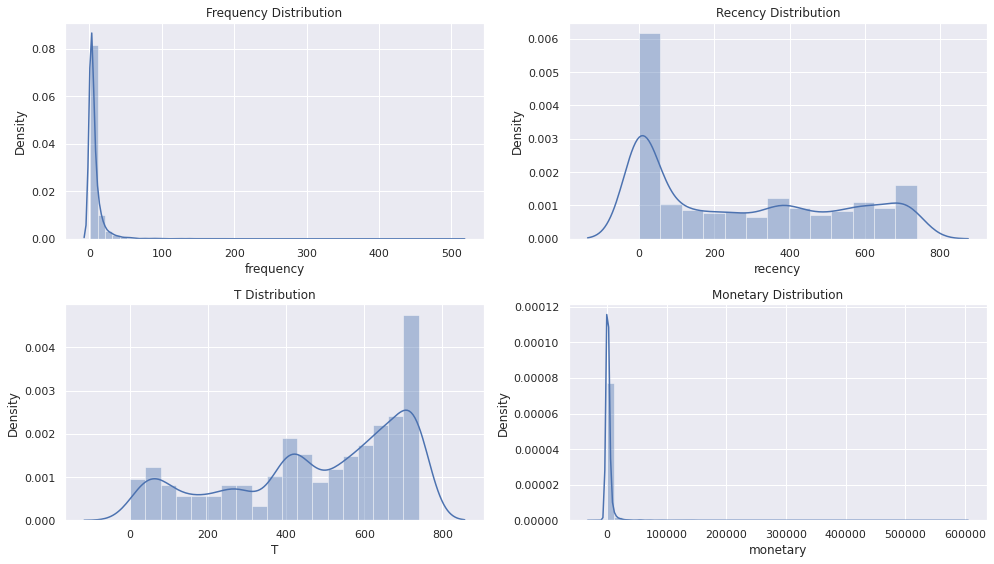

In [ ]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(cltv_df["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(cltv_df["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(cltv_df["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(cltv_df["monetary"])
plt.title("Monetary Distribution")
plt.tight_layout()

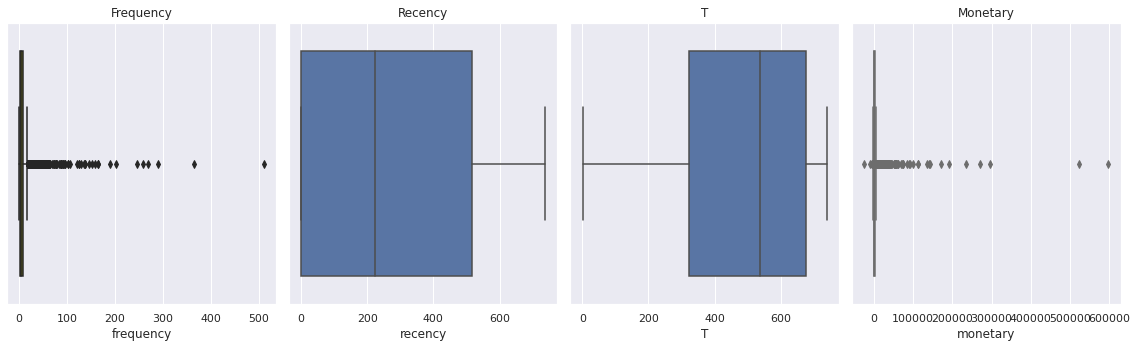

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(cltv_df["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(cltv_df["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(cltv_df["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(cltv_df["monetary"], color = "salmon")
plt.title("Monetary")
plt.tight_layout()

In [ ]:
cltv_df.describe(percentiles = [0.01,0.1,0.25,0.50,0.75,0.90,0.99])

,Customer ID,recency,T,frequency,monetary
count,5942.000000,5942.000000,5942.000000,5942.000000,5942.000000
mean,15316.500000,275.396331,479.229384,7.552339,2801.799459
std,1715.451981,259.688017,223.879537,15.972262,13973.922553
min,12346.000000,0.000000,1.000000,1.000000,-25111.090000
1%,12405.410000,0.000000,16.000000,1.000000,-26.779500
10%,12940.100000,0.000000,90.000000,1.000000,146.182000
25%,13831.250000,0.000000,321.500000,2.000000,325.097500
50%,15316.500000,225.000000,537.000000,4.000000,843.970000
75%,16801.750000,517.000000,675.000000,8.000000,2182.005000
90%,17692.900000,672.000000,732.000000,17.000000,5257.358000


In [ ]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

# monetary nin sıfırdan büyük olanlarının seçelimesi
cltv_df = cltv_df[cltv_df["monetary"] > 0]

# BGNBD için recency ve T'nin haftalık cinsten ifade edilmesi
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

# frequency nin 1 den büyük olanlarının seçilmesi
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
cltv_df.head()

,Customer ID,recency,T,frequency,monetary
1,12347.0,57.428571,57.857143,8,704.165000
2,12348.0,51.714286,62.714286,5,403.880000
3,12349.0,102.285714,105.142857,5,880.908000
6,12352.0,50.857143,56.142857,13,145.323846
7,12353.0,29.142857,58.428571,2,203.380000


In [ ]:
# Fitting the BG/NBD model
from lifetimes import ModifiedBetaGeoFitter
bgf = ModifiedBetaGeoFitter(penalizer_coef=0.0000001)
bgf.fit(cltv_df['frequency'], cltv_df['recency'], cltv_df['T']) 
print(bgf)

<lifetimes.ModifiedBetaGeoFitter: fitted with 4441 subjects, a: 0.61, alpha: 8.06, b: 13.73, r: 1.55>


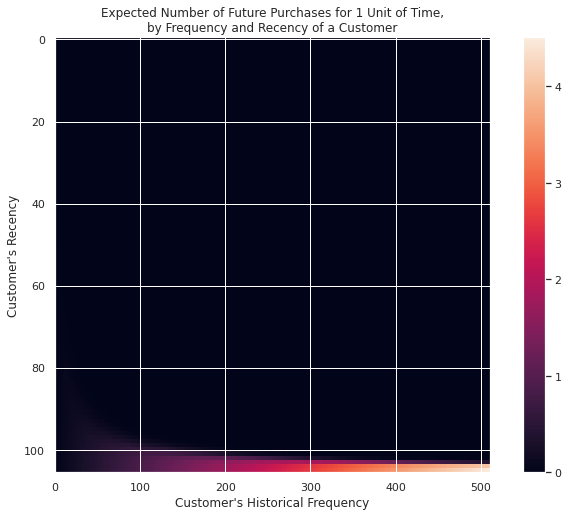

In [ ]:
fig = plt.figure(figsize=(12,8)) 
plot_frequency_recency_matrix(bgf) 

In [ ]:
# 1 week expected purchase (transaction)
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

cltv_df.sort_values("expected_purc_1_week", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week
2565,14911.0,105.285714,105.571429,510,529.899078,4.471598
402,12748.0,104.857143,105.142857,365,136.904466,3.216797
5495,17841.0,105.000000,105.428571,289,240.540450,2.538506
2965,15311.0,105.428571,105.571429,270,420.418778,2.376657
2260,14606.0,105.000000,105.285714,259,116.194517,2.283203
743,13089.0,104.857143,105.428571,247,458.357045,2.166982
1810,14156.0,104.000000,105.571429,202,1468.142030,1.705271
2181,14527.0,105.000000,105.428571,190,135.655474,1.673438
1750,14096.0,13.857143,14.571429,34,1680.026765,1.496468
2300,14646.0,105.000000,105.428571,164,3191.110183,1.445990


In [ ]:
# 1 month expected purchase
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

cltv_df.sort_values("expected_purc_1_month", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
2565,14911.0,105.285714,105.571429,510,529.899078,4.471598,17.749374
402,12748.0,104.857143,105.142857,365,136.904466,3.216797,12.769174
5495,17841.0,105.000000,105.428571,289,240.540450,2.538506,10.077526
2965,15311.0,105.428571,105.571429,270,420.418778,2.376657,9.435299
2260,14606.0,105.000000,105.285714,259,116.194517,2.283203,9.064248
743,13089.0,104.857143,105.428571,247,458.357045,2.166982,8.603076
1810,14156.0,104.000000,105.571429,202,1468.142030,1.705271,6.770644
2181,14527.0,105.000000,105.428571,190,135.655474,1.673438,6.644369
1750,14096.0,13.857143,14.571429,34,1680.026765,1.496468,5.820278
2300,14646.0,105.000000,105.428571,164,3191.110183,1.445990,5.741692


In [ ]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 4441 subjects, p: 0.74, q: 5.13, v: 1723.15>

In [ ]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

cltv_df.sort_values("expected_average_profit", ascending=False).head(20)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_profit
5756,18102.0,105.428571,105.571429,153,3909.903399,1.350878e+00,5.364265e+00,3783.379128
69,12415.0,71.857143,75.428571,33,4341.493636,3.898637e-01,1.547205e+00,3758.997913
5104,17450.0,61.285714,62.714286,61,3829.170328,8.558874e-01,3.387882e+00,3534.551913
2300,14646.0,105.000000,105.428571,164,3191.110183,1.445990e+00,5.741692e+00,3096.412815
1742,14088.0,58.571429,60.285714,20,3120.001000,3.050130e-01,1.209907e+00,2507.544299
3403,15749.0,13.857143,47.571429,4,5383.975000,1.414106e-02,5.625541e-02,2429.879921
1556,13902.0,14.000000,104.571429,8,3801.407500,5.204575e-07,2.074296e-06,2367.681759
11,12357.0,50.714286,55.571429,3,6095.886667,6.793486e-02,2.705766e-01,2334.412058
4338,16684.0,104.000000,104.714286,65,2176.957692,5.820006e-01,2.312475e+00,2029.490459
5905,18251.0,90.000000,102.571429,9,2919.873333,8.698322e-02,3.465879e-01,1921.618275


In [ ]:
# Reset index
cltv = cltv.reset_index()
# Merging the main table and the forecast values table
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
# sorting
cltv_final.sort_values(by="clv", ascending=False).head(10)

In [ ]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

In [ ]:
# Reset index
cltv = cltv.reset_index()
# Merging the main table and the forecast values table
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
# sorting
cltv_final.sort_values(by="clv", ascending=False).head(10)

In [ ]:
# 1 Month CLTV:
cltv_1 = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=1,  # 1 month
                                   freq="W",  # frequency of T
                                   discount_rate=0.01)

cltv_1.head()
cltv_1= cltv_1.reset_index()
cltv_1 = cltv_df.merge(cltv_1, on="Customer ID", how="left")
cltv_1.sort_values(by="clv", ascending=False).head(10)

In [ ]:
# 12 Month CLTV Forecast:

cltv_12 = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=12,  # 1 aylık
                                   freq="W",  # T'nin frekans bilgisi
                                   discount_rate=0.01)

cltv_12.head()
cltv_12 = cltv_12.reset_index()
cltv_12 = cltv_df.merge(cltv_12, on="Customer ID", how="left")
cltv_12.sort_values(by="clv", ascending=False).head(10)